<a href="https://colab.research.google.com/github/medayoubaziz/sales-predictions/blob/main/sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor , RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor


In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/sales_predictions_2023.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###1) Business Understanding :
*Our stakeholders are:

-Bakery owner .

*Their primary goal is:

-Increase the sales of their products .

*They plan to:

-Figure out the best products based on our analysis.

*What do they need/expect?

-Actionable insights/recommendations for which product they can make more to increase the income of their sales .

###2) Data Understanding

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.duplicated().sum()

0

In [5]:
#what columns would we keep :
df = df.drop('Item_Identifier',axis='columns')

In [6]:
#let's check the inconsistency
columns = df.columns
for i in columns :
  df[i].value_counts()
  print( f'the value of the column {i} :\n')
  print(f'{df[i].value_counts()}\n')
  print('\n')

the value of the column Item_Weight :

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: Item_Weight, Length: 415, dtype: int64



the value of the column Item_Fat_Content :

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



the value of the column Item_Visibility :

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64



the value of the column Item_Type :

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      4

In [7]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['LF','low fat'],'Low Fat')
df['Item_Fat_Content']= df['Item_Fat_Content'].replace('reg','Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [8]:
#let's check the nan values :
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
#let's explore the first column
def explore_num(inspection_df , x , figsize=(7.5)) :
  temp_df = inspection_df.copy()
  null_count = temp_df[x].isna().sum()
  null_per = null_count * 100 / len(temp_df)
  nunique = temp_df[x].nunique()
  most_common_value = temp_df[x].value_counts(dropna=False).index[0]
  freq = temp_df[x].value_counts(dropna=False).values[0]
  per_common_value = freq * 100 / len(temp_df)
  gridspec = {'height_ratios':[0.7,0.3]}
  fig,ax = plt.subplots(nrows=2 , figsize=figsize , sharex=True , gridspec_kw=gridspec)
  sns.histplot(data=temp_df , x=x , ax= ax[0])
  sns.boxplot(data=temp_df , x=x , ax=ax[1])
  ax[0].set_title(f"Column: {x}", fontweight='bold' , fontsize = 15)
  sns.despine()
  fig.tight_layout()
  plt.show()
  print(f'There is {null_count} NaN ({round(null_per,2)}%)')
  print(f'There is {nunique} unique values')
  print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
  if per_common_value > 98 :
    print(f'{x}: is a constant or quasi-constant feature and should be dropped')
  else :
    print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
  return fig,ax


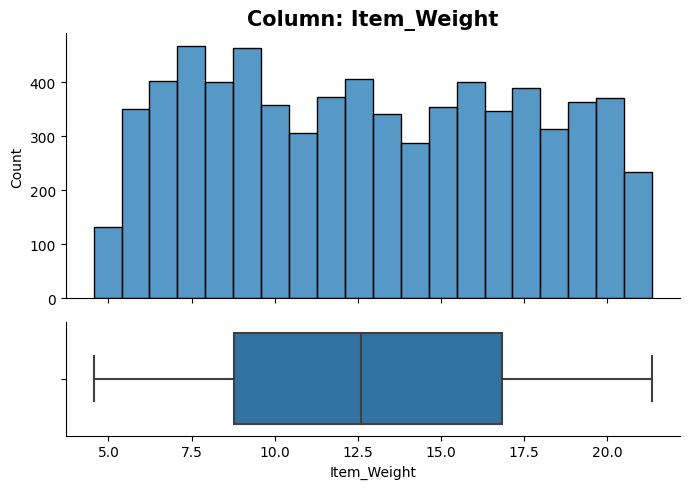

There is 1463 NaN (17.17%)
There is 415 unique values
The most common value is nan , occurs 1463 times (17.17%)
Item_Weight: is neither constant or a quasi-constant feauture and should be kept


In [10]:
explore_num(df,'Item_Weight',figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Item_Weight is a numerical feature.

---

2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

There is 1463 NaN (17.17%) , we should impute with median.

---



3)Is the feature constant or quasi-constant?

Item_Weight: is neither constant or a quasi-constant feauture.

---



4)What is the cardinality? Is it high (>10)?

There is 415 unique values , it's higher than 10.

---



5)Would we know this feature before the target is determined?

Yes.

---



6)Is there a business case/understanding reason to exclude based on our business case?

No.

In [11]:
def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax


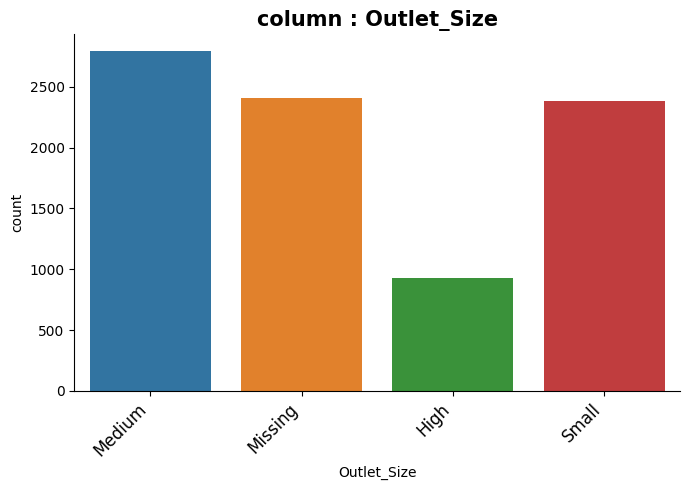

There is 2410 NaN (28.28%)
There is 4 unique values
The most common value is Medium , occurs 2793 times (32.77%)
Outlet_Size: is neither constant or a quasi-constant feauture and should be kept


In [12]:
explore_cat(df,'Outlet_Size', figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Outlet_Size is a ordinal feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

There is 2410 NaN (28.28%) , we should impute with the most common wich is Medium.

---


3)Is the feature constant or quasi-constant?

Outlet_Size: is neither constant or a quasi-constant feauture.

---


4)What is the cardinality? Is it high (>10)?

There is only 4 unique values counting the NaNs.

---


5)Would we know this feature before the target is determined?

Yes.

---


6)Is there a business case/understanding reason to exclude based on our business case?
No.

In [13]:
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


###Exploratory Data Analysis

In [14]:
#our target would be Item_Outlet_Sales
#let's begin with the functions :
def plot_cat_vs_target(inspection_df , x , y='Item_Outlet_Sales' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax

def plot_num_vs_target(inspection_df ,x,y='Item_Outlet_Sales' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax



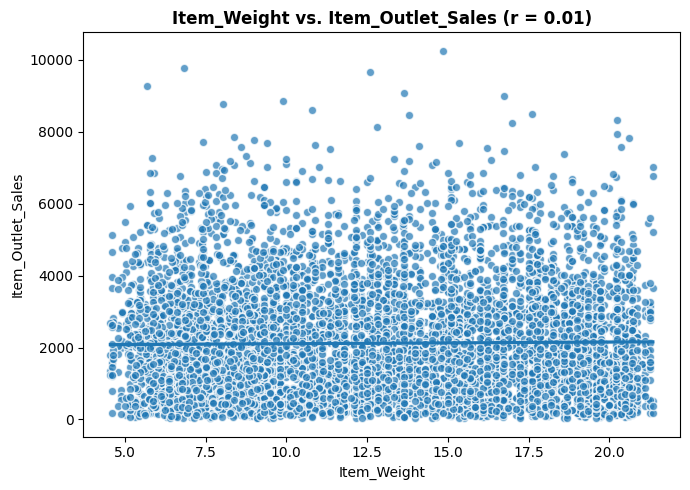

In [15]:
#let's continue on the column : Item_Weight
plot_num_vs_target(df,'Item_Weight' , figsize=(7,5));

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---



8)Does this feature appear to be a predictor of the target?

Yes.

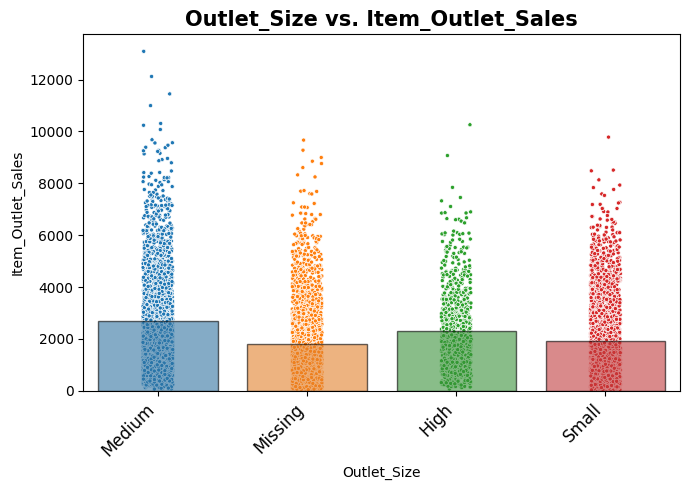

In [16]:
#let's also continue on the column : Outlet_Size
plot_cat_vs_target(df,'Outlet_Size', figsize=(7,5));

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

Yes.

In [17]:
#let's continue with the cat features
df.select_dtypes('object').columns

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

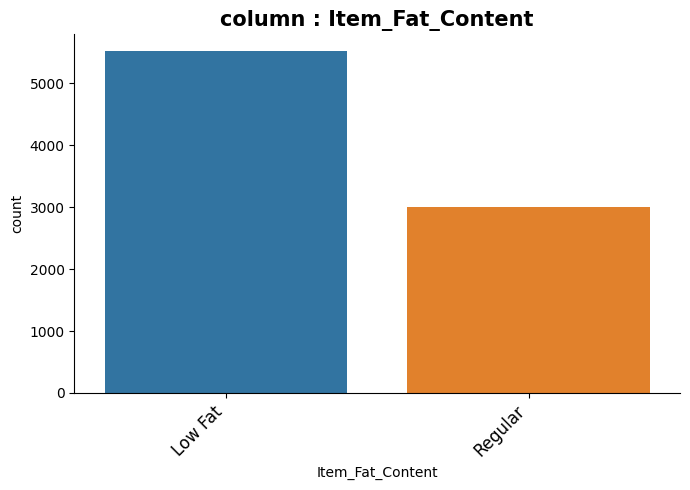

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is Low Fat , occurs 5517 times (64.73%)
Item_Fat_Content: is neither constant or a quasi-constant feauture and should be kept


In [18]:
explore_cat(df,'Item_Fat_Content',figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

It's a categorical feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

There's no missing values.

---


3)Is the feature constant or quasi-constant?
Item_Fat_Content: is neither constant or a quasi-constant feauture.

---


4)What is the cardinality? Is it high (>10)?

There is 2 unique values

---


5)Would we know this feature before the target is determined?

Yes.

---


6)Is there a business case/understanding reason to exclude based on our business case?

No.

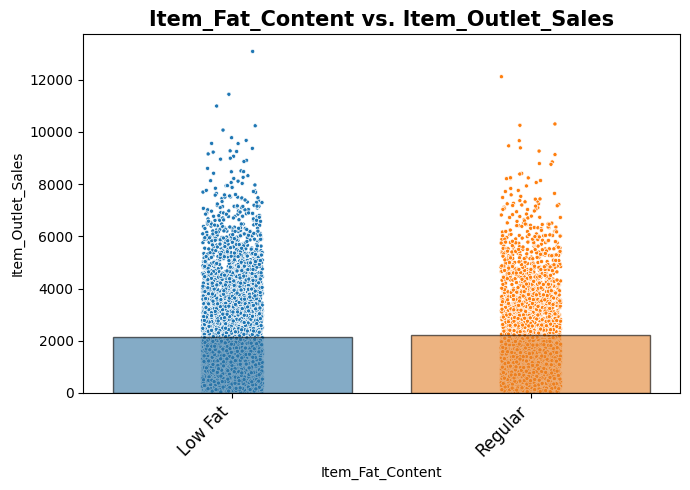

In [19]:
plot_cat_vs_target(df,'Item_Fat_Content',figsize=(7,5));

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

No.

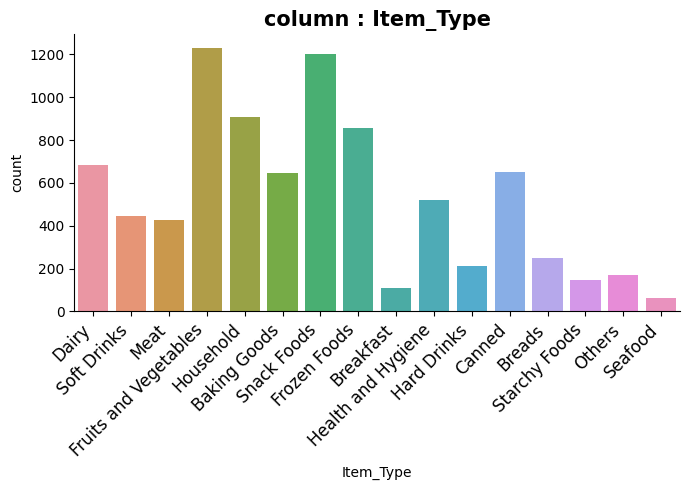

There is 0 NaN (0.0%)
There is 16 unique values
The most common value is Fruits and Vegetables , occurs 1232 times (14.46%)
Item_Type: is neither constant or a quasi-constant feauture and should be kept


In [20]:
explore_cat(df,'Item_Type',figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Categorical feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

There is 0 null value.

---


3)Is the feature constant or quasi-constant?

Item_Type: is neither constant or a quasi-constant feauture.

---


4)What is the cardinality? Is it high (>10)?

There is 16 unique values , it's higher than 10 .

---


5)Would we know this feature before the target is determined?

Yes.

---


6)Is there a business case/understanding reason to exclude based on our business case?

No.

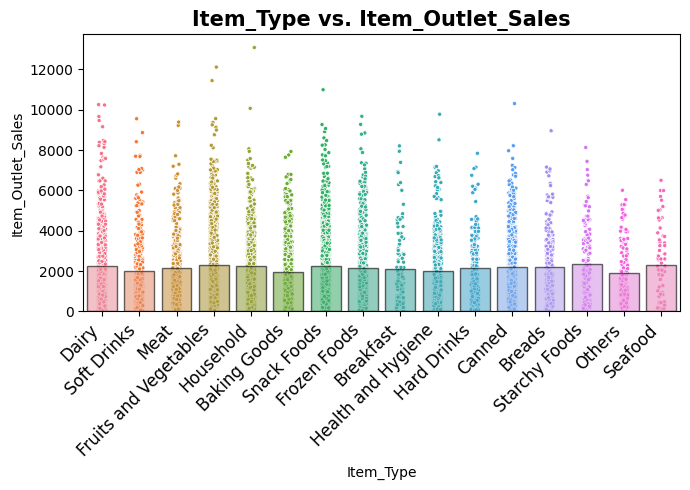

In [21]:
plot_cat_vs_target(df,'Item_Type');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

Yes.

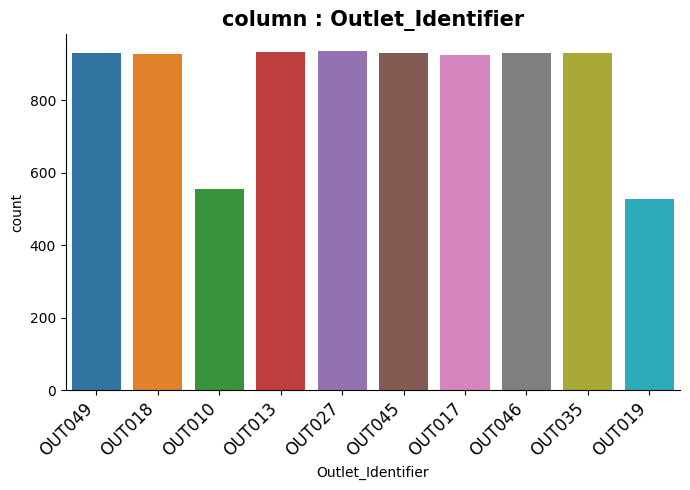

There is 0 NaN (0.0%)
There is 10 unique values
The most common value is OUT027 , occurs 935 times (10.97%)
Outlet_Identifier: is neither constant or a quasi-constant feauture and should be kept


In [22]:
explore_cat(df,'Outlet_Identifier');

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Categorical feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

0 null values.

---


3)Is the feature constant or quasi-constant?

Outlet_Identifier: is neither constant or a quasi-constant feauture.

---


4)What is the cardinality? Is it high (>10)?

There is 10 unique values.

---


5)Would we know this feature before the target is determined?

Yes.

---



6)Is there a business case/understanding reason to exclude based on our business case?

Maybe .

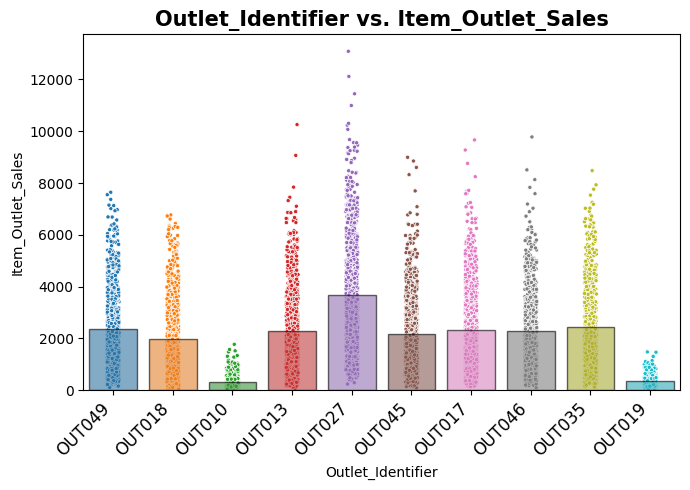

In [23]:
plot_cat_vs_target(df,'Outlet_Identifier');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Maybe.

---


8)Does this feature appear to be a predictor of the target?

Maybe.

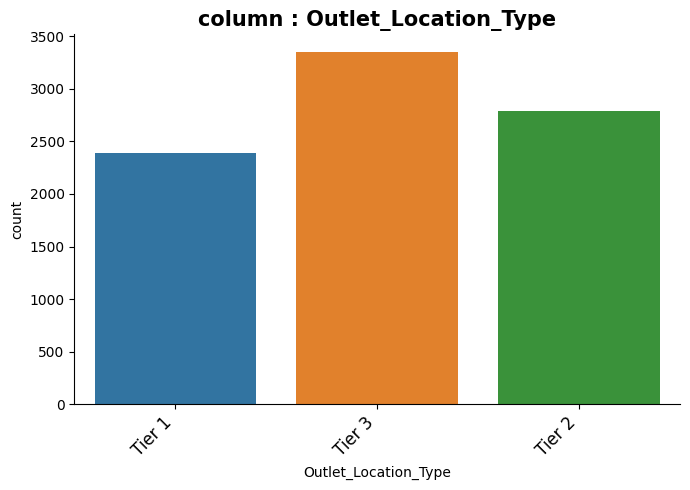

There is 0 NaN (0.0%)
There is 3 unique values
The most common value is Tier 3 , occurs 3350 times (39.31%)
Outlet_Location_Type: is neither constant or a quasi-constant feauture and should be kept


In [24]:
explore_cat(df,'Outlet_Location_Type');

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Categorical feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

0 null values.

---


3)Is the feature constant or quasi-constant?

Outlet_Location_Type: is neither constant or a quasi-constant feauture.

---


4)What is the cardinality? Is it high (>10)?

There is 3 unique values.

---


5)Would we know this feature before the target is determined?

Yes.

---


6)Is there a business case/understanding reason to exclude based on our business case?

No.

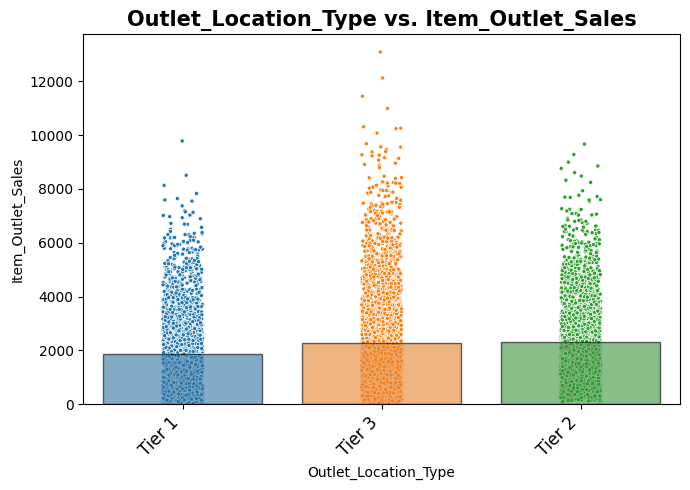

In [25]:
plot_cat_vs_target(df,'Outlet_Location_Type');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

Yes.

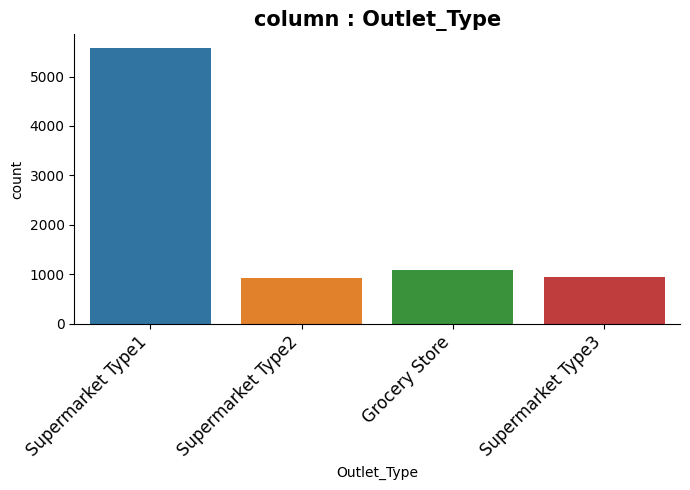

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is Supermarket Type1 , occurs 5577 times (65.43%)
Outlet_Type: is neither constant or a quasi-constant feauture and should be kept


In [26]:
explore_cat(df,'Outlet_Type');

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Categorical feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

0 null values.

---


3)Is the feature constant or quasi-constant?

Outlet_Type: is neither constant or a quasi-constant feauture.

---


4)What is the cardinality? Is it high (>10)?

There is 4 unique values.

---


5)Would we know this feature before the target is determined?

Yes.

---


6)Is there a business case/understanding reason to exclude based on our business case?

No.

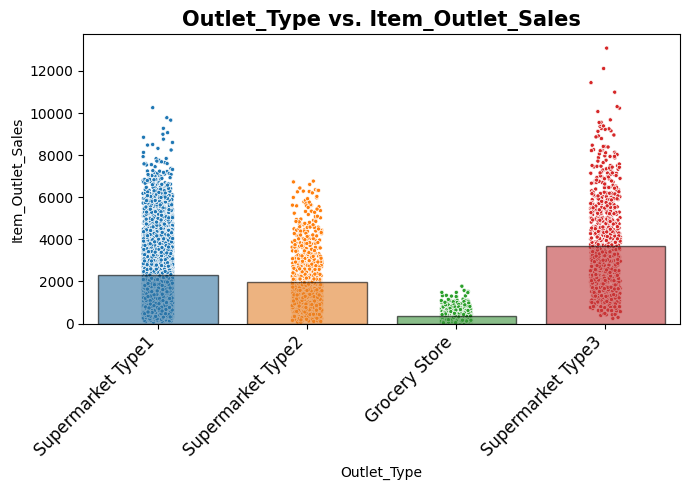

In [27]:
plot_cat_vs_target(df,'Outlet_Type');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

No.

In [28]:
#let's do the numerical features
df.select_dtypes('number').columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

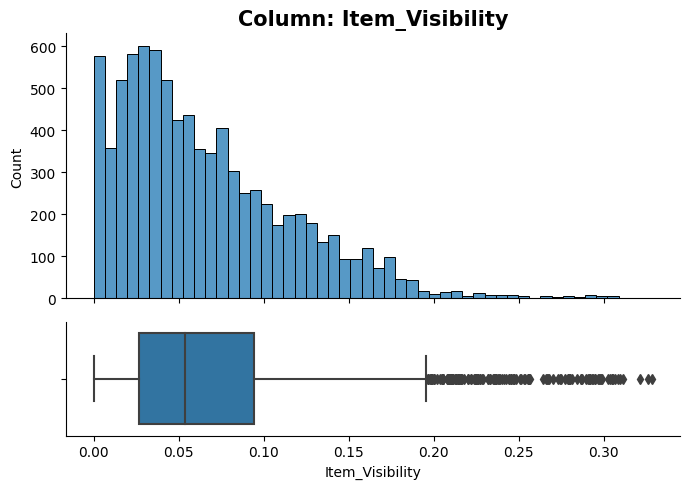

There is 0 NaN (0.0%)
There is 7880 unique values
The most common value is 0.0 , occurs 526 times (6.17%)
Item_Visibility: is neither constant or a quasi-constant feauture and should be kept


In [29]:
explore_num(df,'Item_Visibility',figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Numercial feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

0 null values.

---


3)Is the feature constant or quasi-constant?

Item_Visibility: is neither constant or a quasi-constant feauture.

---

4)Would we know this feature before the target is determined?

Yes.

---


5)Is there a business case/understanding reason to exclude based on our business case?

No.

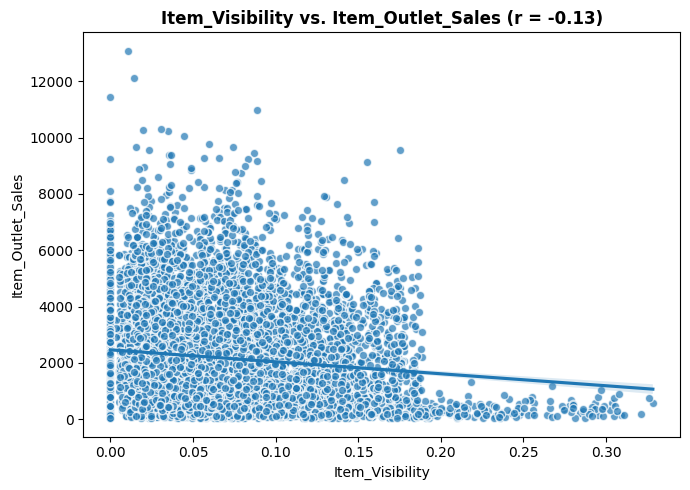

In [30]:
plot_num_vs_target(df,'Item_Visibility');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

Yes.

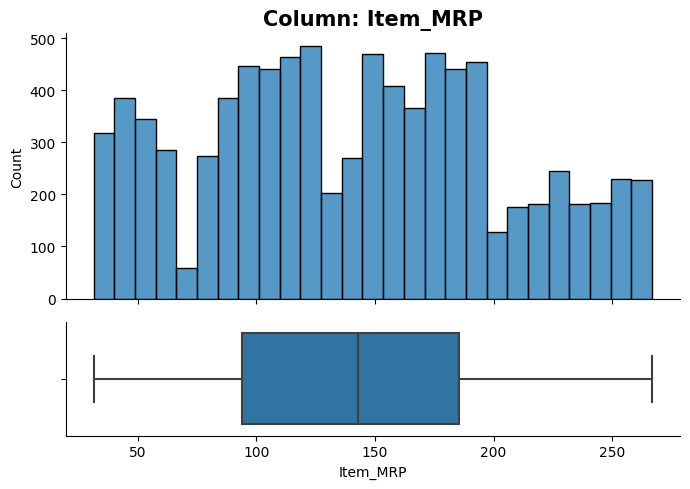

There is 0 NaN (0.0%)
There is 5938 unique values
The most common value is 172.0422 , occurs 7 times (0.08%)
Item_MRP: is neither constant or a quasi-constant feauture and should be kept


In [31]:
explore_num(df,'Item_MRP',figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Numercial feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

0 null values.

---


3)Is the feature constant or quasi-constant?

Item_MRP: is neither constant or a quasi-constant feauture.

---


4)Would we know this feature before the target is determined?

Yes.

---


5)Is there a business case/understanding reason to exclude based on our business case?

No.

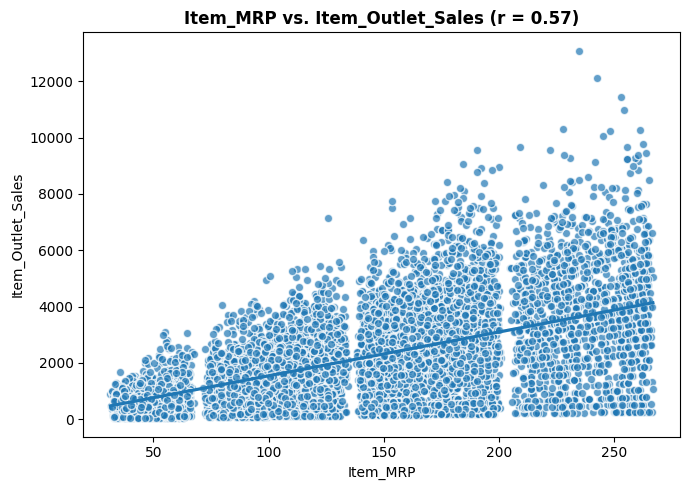

In [32]:
plot_num_vs_target(df,'Item_MRP');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.

---


8)Does this feature appear to be a predictor of the target?

Yes.

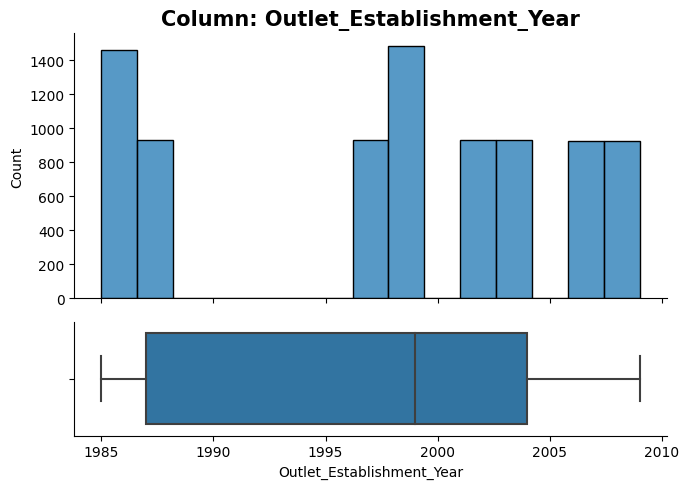

There is 0 NaN (0.0%)
There is 9 unique values
The most common value is 1985 , occurs 1463 times (17.17%)
Outlet_Establishment_Year: is neither constant or a quasi-constant feauture and should be kept


In [33]:
explore_num(df,'Outlet_Establishment_Year',figsize=(7,5));

1)What type of feature is it? (Categorical (nominal), ordinal, numeric)

Numercial feature.

---


2)How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

0 null values.

---


3)Is the feature constant or quasi-constant?

Outlet_Establishment_Year: is neither constant or a quasi-constant feauture.

---



4)Would we know this feature before the target is determined?

Yes.

---


5)Is there a business case/understanding reason to exclude based on our business case?

No.

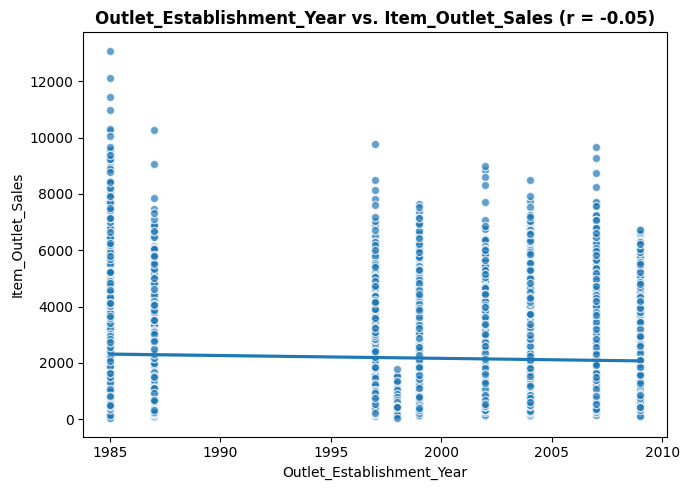

In [34]:
plot_num_vs_target(df,'Outlet_Establishment_Year');

7)Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes.
8)Does this feature appear to be a predictor of the target?

No.

###3) Data Preparation

In [35]:
#let's begin with train and test split
y = df['Item_Outlet_Sales']
X = df.drop('Item_Outlet_Sales',axis='columns')
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [36]:
#let's separate our feature :
num_cols = X_train.select_dtypes('number').columns
ord_cols = ['Outlet_Size']
cat_cols = X_train.select_dtypes('object').drop('Outlet_Size', axis='columns').columns

In [37]:
num_imputer = SimpleImputer(strategy='median')
ord_imputer = SimpleImputer(strategy='most_frequent')
cat_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
scaler= StandardScaler()
ord_order = ['Small','Medium','High']
ord_encoder = OrdinalEncoder(categories=[ord_order])

In [38]:
num_pipe = make_pipeline(num_imputer,scaler)
ord_pipe = make_pipeline(ord_imputer,ord_encoder,scaler)

In [39]:
num_tuple = ('numercial',num_pipe,num_cols)
ord_tuple = ('ordinal',ord_pipe,ord_cols)
cat_tuple = ('categorical',cat_encoder,cat_cols)

In [40]:
transformer = ColumnTransformer([num_tuple,ord_tuple,cat_tuple],verbose_feature_names_out=False)
transformer

ColumnTransformer(transformers=[('numercial',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [41]:
transformer.fit(X_train)

ColumnTransformer(transformers=[('numercial',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [42]:
X_train_final = transformer.transform(X_train)
X_test_final = transformer.transform(X_test)

###4) Modeling

In [43]:
#let's begin with the functions
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression (reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False) :
   y_train_pred = reg.predict(X_train)
   results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
   y_test_pred = reg.predict(X_test)
   results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
   if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    results_df = results_df.set_index('Label')
    results_df.index.name=None
    return results_df.round(3)


In [44]:
linear_regression = LinearRegression()
linear_pipe = make_pipeline(transformer,linear_regression)
linear_pipe.fit(X_train, y_train);
evaluate_regression(linear_pipe,X_train,y_train,X_test,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.131
- MSE = 1,297,556.865
- RMSE = 1,139.104
- R^2 = 0.562
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.089
- MSE = 1,194,326.602
- RMSE = 1,092.853
- R^2 = 0.567


In [45]:
tree = DecisionTreeRegressor(random_state=42)
tree_pipe = make_pipeline(transformer,tree)
tree_pipe.fit(X_train,y_train);
evaluate_regression(tree_pipe,X_train,y_train,X_test,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.000
- MSE = 0.000
- RMSE = 0.000
- R^2 = 1.000
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,033.258
- MSE = 2,225,112.449
- RMSE = 1,491.681
- R^2 = 0.194


In [46]:
tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [47]:
depths = list(range(2,50))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
  random_forest = DecisionTreeRegressor(max_depth=depth, random_state=42)
  random_forest.fit(X_train_final,y_train)
  train_preds = random_forest.predict(X_train_final)
  test_preds = random_forest.predict(X_test_final)
  train_score = r2_score(y_train, train_preds)
  test_score = r2_score(y_test, test_preds)
  scores.loc[depth, 'Train Score'] = train_score
  scores.loc[depth, 'Test Score'] = test_score
  scores = scores.sort_values(by='Test Score', ascending=False)
scores.head()



,Test Score,Train Score
5,0.594709,0.603933
4,0.584005,0.582625
6,0.582307,0.615153
7,0.576396,0.626842
8,0.558872,0.64384


In [48]:
tree_tuned = DecisionTreeRegressor(max_depth=5,random_state=42)

In [49]:
tree_tuned_pipe = make_pipeline(transformer,tree_tuned)
tree_tuned_pipe.fit(X_train,y_train)
evaluate_regression(tree_tuned_pipe,X_train,y_train,X_test,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 762.640
- MSE = 1,172,142.044
- RMSE = 1,082.655
- R^2 = 0.604
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 738.356
- MSE = 1,118,187.946
- RMSE = 1,057.444
- R^2 = 0.595


In [50]:
yy = df['Item_Outlet_Sales']
XX = df.drop(['Item_Outlet_Sales','Outlet_Identifier'],axis='columns')
XX_train,XX_test,yy_train,yy_test = train_test_split(XX,yy,random_state=42)
num_colss = XX_train.select_dtypes('number').columns
ord_colss = ['Outlet_Size']
cat_colss = XX_train.select_dtypes('object').drop('Outlet_Size', axis='columns').columns
nums_tuple = ('numercial',num_pipe,num_colss)
ords_tuple = ('ordinal',ord_pipe,ord_colss)
cats_tuple = ('categorical',cat_encoder,cat_colss)
transformers = ColumnTransformer([nums_tuple,ords_tuple,cats_tuple],verbose_feature_names_out=False)
linears_pipe = make_pipeline(transformers,linear_regression)
linears_pipe.fit(XX_train, yy_train);
evaluate_regression(linears_pipe,XX_train,yy_train,XX_test,yy_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.410
- MSE = 1,300,451.585
- RMSE = 1,140.373
- R^2 = 0.561
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 805.309
- MSE = 1,197,605.631
- RMSE = 1,094.352
- R^2 = 0.566


In [51]:
trees_pipe = make_pipeline(transformers,tree)
trees_pipe.fit(XX_train,yy_train);
evaluate_regression(trees_pipe,XX_train,yy_train,XX_test,yy_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.000
- MSE = 0.000
- RMSE = 0.000
- R^2 = 1.000
------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,045.464
- MSE = 2,271,600.979
- RMSE = 1,507.183
- R^2 = 0.177


In [59]:
transformers.fit(XX_train)
XX_train_final = transformers.transform(XX_train)
XX_test_final = transformers.transform(XX_test)
depths = list(range(2,50))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
  treee = DecisionTreeRegressor(max_depth=depth, random_state=42)
  treee.fit(XX_train_final,yy_train)
  train_preds = treee.predict(XX_train_final)
  test_preds = treee.predict(XX_test_final)
  train_score = r2_score(yy_train, train_preds)
  test_score = r2_score(yy_test, test_preds)
  scores.loc[depth, 'Train Score'] = train_score
  scores.loc[depth, 'Test Score'] = test_score
  scores = scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
5,0.594709,0.603933
4,0.584005,0.582625
6,0.582568,0.615063
7,0.576813,0.626453
8,0.560279,0.642722
